<a href="https://colab.research.google.com/github/felluksch/bike-hires/blob/main/timeseries_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook fits a many-to-one LSTM network for multivariate time series forecasting. Based on weather data, we try to predict the daily number of bicycles hires in London.

We import the necessary packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import optuna

np.random.seed(10)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Next, we load the data. The first data set contains the feature that we want to predict: the daily number of bike hires in London. The second data set comprises weather data (hourly temperature, pressure and relative humidity). In addition, we generate a variable that contains the day of the week.

In [2]:
url1 = "https://data.london.gov.uk/download/number-bicycle-hires/ac29363e-e0cb-47cc-a97a-e216d900a6b0/tfl-daily-cycle-hires.xlsx"
bike_hires = pd.read_excel(url1, sheet_name=1, usecols=[0,1], parse_dates=[0], index_col=0, names=["date", "num_hires"]) # we're only interested in the two first cols of the second sheet
bike_hires["weekday"] = bike_hires.index.dayofweek
bike_hires["week"] = bike_hires.index.isocalendar().week

url2 = "https://bulk.meteostat.net/hourly/03779.csv.gz"
weather = pd.read_csv(url2, compression='gzip', usecols=[0,1,2,4,10], parse_dates=[0], index_col=0, names=["date", "hour", "temp", "rel_hum", "pressure"])
weather = weather['2010-07-30':'2021-08-31']

The bike hires data is available for 2010 to 2021. However, we notice that our weather data set has missing data for 2010-2018. We can thus only use data for 2018 to 2021. As the weather data contains hourly records but not 24 hours are covered for all days in the data set, we choose data for 3pm as a proxy for the weather of the given day.

In [3]:
weather = weather[weather.hour == 15]
assert len(weather) == (weather.index.max() - weather.index.min()).days + 1
print("data available from", weather.index.min(), "to", weather.index.max())

bike_hires = bike_hires['2018-01-29':'2021-08-31']
assert len(bike_hires) == (weather.index.max() - weather.index.min()).days + 1

data available from 2018-01-29 00:00:00 to 2021-08-31 00:00:00


We quickly visualise the data.

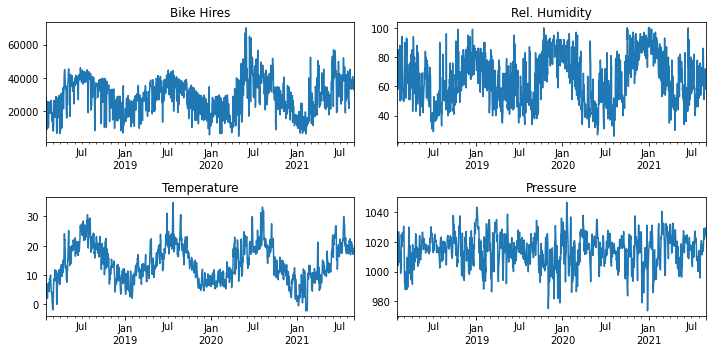

In [4]:
 fig, axes = plt.subplots(2,2, figsize=(10, 5))

 bike_hires["num_hires"].plot(ax=axes[0,0], title="Bike Hires").set_xlabel(None)
 weather["temp"].plot(ax=axes[1,0], title="Temperature").set_xlabel(None)
 weather["rel_hum"].plot(ax=axes[0,1], title="Rel. Humidity").set_xlabel(None)
 weather["pressure"].plot(ax=axes[1,1], title="Pressure").set_xlabel(None)
 plt.tight_layout()

We use the function `seasonal_decompose` from the statsmodels package to visualise inherent trend and seasonality of the timeseries. We set the `freq` argument to 365 as we can see from the plot above that the timeseries seems to exhibit periodicity following a yearly pattern. However, the trend is highly non-linear. We'll see if the network is capable of modelling the system.

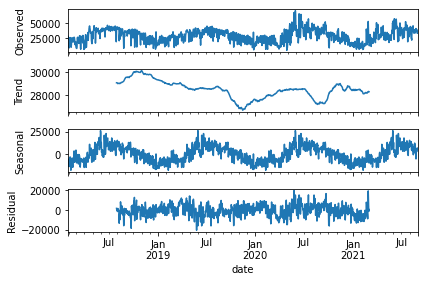

In [5]:
seasonal_decompose(bike_hires["num_hires"], freq=365).plot().show()

Now we want to know whether some of the predictor variables are redundant. We print a correlation matrix, however, the values are not too high. We keep all features.

In [6]:
weather.corr()

,hour,temp,rel_hum,pressure
hour,NaN,NaN,NaN,NaN
temp,NaN,1.000000,-0.609505,0.154666
rel_hum,NaN,-0.609505,1.000000,-0.379380
pressure,NaN,0.154666,-0.379380,1.000000


We can get started with defining the hyperparameters of the model. We feed the model the past 90 observations (days) and want it to predict the values for 7 days in the future.

In [7]:
PAST = 90
FUTURE = 7
BATCHSIZE = 128
EPOCHS = 200
TRAIN_SIZE = 0.7

We create the target variable `num_hires_lagged` (= `num hires` in `FUTURE` timesteps). We also create a train-test split and standardise the data.

In [8]:
data = bike_hires.join(weather[["temp", "rel_hum", "pressure"]], on="date") # join dfs
assert len(data) == len(bike_hires) == len(weather)

data["num_hires_lagged"] = data["num_hires"].shift(-FUTURE) # create target
data = data[data["num_hires_lagged"].notna()] # drop rows for which we cannot create the target

split = round(TRAIN_SIZE * len(data))

scaler = StandardScaler() 
train_data = scaler.fit_transform(data.values[:split, :])
test_data = scaler.transform(data.values[split:, :])

assert len(train_data) + len(test_data) == len(data)

As we're trying to build a many-to-one LSTM, we need the input data in the following shape, so that we can use multiple sequences (all predictors) to predict a future value: 

X: `(num_obs, sequence_length, num_features)`.

y: `(num_obs,)`.

For every item in the vector y, X holds a matrix of 5 vectors: the past 90 observations for `num_hires`, `weekday`, `week`, `temp`, `rel_hum`, and `pressure`.

In [9]:
def create_many_to_one_data(matrix, PAST):
  X = np.empty((matrix.shape[0], PAST, matrix.shape[1]))
  X[:,:,:] = np.nan

  for ri in range(matrix.shape[0]): # for each time record
    for ci in range(matrix.shape[1]): # for each feature per row 
      if ri-PAST >= 0:
        X[ri,:,ci] = matrix[ri-PAST:ri,ci]

  return X[PAST:] # first rows are nans

y_col = data.shape[1] - 1
data_full = np.concatenate([train_data, test_data])
X = create_many_to_one_data(data_full[:, :y_col], PAST)
X_train = X[:split-PAST, :, :]
X_test = X[split-PAST:, :, :]
y_train = train_data[PAST:, y_col] # first obs are nans
y_test = test_data[:, y_col]

assert len(X_train) == len(y_train) == len(train_data) - PAST
assert len(X_test) == len(y_test) == len(test_data)
assert len(X_train) + len(X_test) == len(data) - PAST
assert X_train[0, 0, 3] == train_data[0, 3]

Now we can specify the model architecture and search the parameter space for optimal hyperparameters with the optuna package. We optimise the learning rate of the optimiser, the number of LSTM layers plus the number of hidden states and dropout rates per LSTM layer.

In [10]:
def define_model(trial):

  model = keras.Sequential()
  model.add(keras.Input(shape=(X_train.shape[1], X_train.shape[2])))

  n_layers = trial.suggest_int("n_layers", 1, 5)
  for i in range(n_layers - 1):
      num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)
      dropout = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.6, step=0.1)
      model.add(keras.layers.LSTM(num_hidden, return_sequences=True, dropout=dropout))

  num_hidden_last = trial.suggest_int("n_units_l{}".format(n_layers - 1), 4, 128, log=True)
  dropout_last = trial.suggest_float("dropout_l{}".format(n_layers - 1), 0.0, 0.6, step=0.1)
  model.add(keras.layers.LSTM(num_hidden_last, dropout=dropout_last))
  model.add(keras.layers.Dense(1))
  
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
  model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=keras.metrics.RootMeanSquaredError())
  return model

path_checkpoint = "model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

def objective(trial):
  keras.backend.clear_session()

  model = define_model(trial)

  model.fit(
        X_train,
        y_train,
        batch_size=BATCHSIZE,
        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5), 
                   modelckpt_callback, 
                   optuna.integration.TFKerasPruningCallback(trial, "val_loss")
                   ],
        epochs=EPOCHS,
        validation_data=(X_test, y_test),
        verbose=1,
  )

  model.save('content/models/trial_{}'.format(trial.number)) # save model

  # Evaluate the model accuracy on the validation set
  score = model.evaluate(X_test, y_test, verbose=0)
  return score[1]

sampler = optuna.samplers.TPESampler(seed=10) 

study = optuna.create_study(sampler=sampler, direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, timeout=5000)
pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

[I 2021-10-12 09:59:15,363] A new study created in memory with name: no-name-d4515e22-d20a-429b-b12e-3fdc6293d011


Epoch 1/200
7/7 [==============================] - 9s 496ms/step - loss: 1.0019 - root_mean_squared_error: 1.0010 - val_loss: 1.1436 - val_root_mean_squared_error: 1.0694

Epoch 00001: val_loss improved from inf to 1.14364, saving model to model_checkpoint.h5
Epoch 2/200
7/7 [==============================] - 2s 264ms/step - loss: 0.9880 - root_mean_squared_error: 0.9940 - val_loss: 1.1266 - val_root_mean_squared_error: 1.0614

Epoch 00002: val_loss improved from 1.14364 to 1.12656, saving model to model_checkpoint.h5
Epoch 3/200
7/7 [==============================] - 2s 258ms/step - loss: 0.9736 - root_mean_squared_error: 0.9867 - val_loss: 1.1080 - val_root_mean_squared_error: 1.0526

Epoch 00003: val_loss improved from 1.12656 to 1.10796, saving model to model_checkpoint.h5
Epoch 4/200
7/7 [==============================] - 2s 259ms/step - loss: 0.9592 - root_mean_squared_error: 0.9794 - val_loss: 1.0856 - val_root_mean_squared_error: 1.0419

Epoch 00004: val_loss improved from 1.10

INFO:tensorflow:Assets written to: content/models/trial_0/assets


INFO:tensorflow:Assets written to: content/models/trial_0/assets
[I 2021-10-12 10:00:33,842] Trial 0 finished with value: 0.7885842323303223 and parameters: {'n_layers': 4, 'n_units_l0': 4, 'dropout_l0': 0.4, 'n_units_l1': 52, 'dropout_l1': 0.30000000000000004, 'n_units_l2': 8, 'dropout_l2': 0.1, 'n_units_l3': 54, 'dropout_l3': 0.1, 'lr': 0.0001502033532716473}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 10s 629ms/step - loss: 0.6854 - root_mean_squared_error: 0.8279 - val_loss: 0.7132 - val_root_mean_squared_error: 0.8445

Epoch 00001: val_loss did not improve from 0.61684
Epoch 2/200
7/7 [==============================] - 3s 443ms/step - loss: 0.5880 - root_mean_squared_error: 0.7668 - val_loss: 0.7212 - val_root_mean_squared_error: 0.8492

Epoch 00002: val_loss did not improve from 0.61684
Epoch 3/200
7/7 [==============================] - 3s 403ms/step - loss: 0.5598 - root_mean_squared_error: 0.7482 - val_loss: 0.7320 - val_root_mean_squared_error: 0.8556

Epoch 00003: val_loss did not improve from 0.61684
Epoch 4/200
7/7 [==============================] - 3s 395ms/step - loss: 0.5458 - root_mean_squared_error: 0.7388 - val_loss: 0.7572 - val_root_mean_squared_error: 0.8702

Epoch 00004: val_loss did not improve from 0.61684
Epoch 5/200
7/7 [==============================] - 3s 394ms/step - loss: 0.5475 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: content/models/trial_1/assets


INFO:tensorflow:Assets written to: content/models/trial_1/assets
[I 2021-10-12 10:01:51,542] Trial 1 finished with value: 0.8055651783943176 and parameters: {'n_layers': 4, 'n_units_l0': 109, 'dropout_l0': 0.0, 'n_units_l1': 22, 'dropout_l1': 0.5, 'n_units_l2': 32, 'dropout_l2': 0.5, 'n_units_l3': 10, 'dropout_l3': 0.6, 'lr': 0.002686281782188217}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 7s 352ms/step - loss: 0.7974 - root_mean_squared_error: 0.8930 - val_loss: 0.7848 - val_root_mean_squared_error: 0.8859

Epoch 00001: val_loss did not improve from 0.61684
Epoch 2/200
7/7 [==============================] - 1s 167ms/step - loss: 0.6159 - root_mean_squared_error: 0.7848 - val_loss: 0.7339 - val_root_mean_squared_error: 0.8567

Epoch 00002: val_loss did not improve from 0.61684
Epoch 3/200
7/7 [==============================] - 1s 166ms/step - loss: 0.6067 - root_mean_squared_error: 0.7789 - val_loss: 0.7089 - val_root_mean_squared_error: 0.8420

Epoch 00003: val_loss did not improve from 0.61684
Epoch 4/200
7/7 [==============================] - 1s 165ms/step - loss: 0.5856 - root_mean_squared_error: 0.7652 - val_loss: 0.6695 - val_root_mean_squared_error: 0.8182

Epoch 00004: val_loss did not improve from 0.61684
Epoch 5/200
7/7 [==============================] - 1s 167ms/step - loss: 0.5775 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_2/assets


INFO:tensorflow:Assets written to: content/models/trial_2/assets
[I 2021-10-12 10:02:31,140] Trial 2 finished with value: 0.8076299428939819 and parameters: {'n_layers': 3, 'n_units_l0': 6, 'dropout_l0': 0.2, 'n_units_l1': 40, 'dropout_l1': 0.30000000000000004, 'n_units_l2': 17, 'dropout_l2': 0.4, 'lr': 0.0010623716801588566}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 10s 596ms/step - loss: 0.7092 - root_mean_squared_error: 0.8421 - val_loss: 0.7114 - val_root_mean_squared_error: 0.8435

Epoch 00001: val_loss did not improve from 0.61684
Epoch 2/200
7/7 [==============================] - 1s 204ms/step - loss: 0.5782 - root_mean_squared_error: 0.7604 - val_loss: 0.6840 - val_root_mean_squared_error: 0.8270

Epoch 00002: val_loss did not improve from 0.61684
Epoch 3/200
7/7 [==============================] - 1s 204ms/step - loss: 0.5606 - root_mean_squared_error: 0.7487 - val_loss: 0.6867 - val_root_mean_squared_error: 0.8287

Epoch 00003: val_loss did not improve from 0.61684
Epoch 4/200
7/7 [==============================] - 1s 202ms/step - loss: 0.5543 - root_mean_squared_error: 0.7445 - val_loss: 0.7363 - val_root_mean_squared_error: 0.8581

Epoch 00004: val_loss did not improve from 0.61684
Epoch 5/200
7/7 [==============================] - 1s 203ms/step - loss: 0.5613 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: content/models/trial_3/assets


INFO:tensorflow:Assets written to: content/models/trial_3/assets
[I 2021-10-12 10:03:15,729] Trial 3 finished with value: 0.817861020565033 and parameters: {'n_layers': 4, 'n_units_l0': 31, 'dropout_l0': 0.5, 'n_units_l1': 23, 'dropout_l1': 0.6, 'n_units_l2': 11, 'dropout_l2': 0.0, 'n_units_l3': 10, 'dropout_l3': 0.0, 'lr': 0.0045432083368798296}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 3s 136ms/step - loss: 0.7290 - root_mean_squared_error: 0.8538 - val_loss: 0.7088 - val_root_mean_squared_error: 0.8419

Epoch 00001: val_loss did not improve from 0.61684
Epoch 2/200
7/7 [==============================] - 0s 62ms/step - loss: 0.6253 - root_mean_squared_error: 0.7907 - val_loss: 0.6608 - val_root_mean_squared_error: 0.8129

Epoch 00002: val_loss did not improve from 0.61684
Epoch 3/200
7/7 [==============================] - 0s 66ms/step - loss: 0.5757 - root_mean_squared_error: 0.7588 - val_loss: 0.6651 - val_root_mean_squared_error: 0.8155

Epoch 00003: val_loss did not improve from 0.61684
Epoch 4/200
7/7 [==============================] - 0s 65ms/step - loss: 0.5564 - root_mean_squared_error: 0.7459 - val_loss: 0.6639 - val_root_mean_squared_error: 0.8148

Epoch 00004: val_loss did not improve from 0.61684
Epoch 5/200
7/7 [==============================] - 0s 64ms/step - loss: 0.5241 - root_mean_squared_error: 0.723

INFO:tensorflow:Assets written to: content/models/trial_4/assets


INFO:tensorflow:Assets written to: content/models/trial_4/assets
[I 2021-10-12 10:03:32,620] Trial 4 finished with value: 0.8248534798622131 and parameters: {'n_layers': 1, 'n_units_l0': 33, 'dropout_l0': 0.30000000000000004, 'lr': 0.0043508488031796955}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 3s 207ms/step - loss: 0.7217 - root_mean_squared_error: 0.8495 - val_loss: 0.6301 - val_root_mean_squared_error: 0.7938

Epoch 00001: val_loss did not improve from 0.61684
Epoch 2/200
7/7 [==============================] - 1s 143ms/step - loss: 0.6008 - root_mean_squared_error: 0.7751 - val_loss: 0.6507 - val_root_mean_squared_error: 0.8066

Epoch 00002: val_loss did not improve from 0.61684
Epoch 3/200
7/7 [==============================] - 1s 144ms/step - loss: 0.5452 - root_mean_squared_error: 0.7384 - val_loss: 0.6533 - val_root_mean_squared_error: 0.8083

Epoch 00003: val_loss did not improve from 0.61684
Epoch 4/200
7/7 [==============================] - 1s 142ms/step - loss: 0.5371 - root_mean_squared_error: 0.7329 - val_loss: 0.6616 - val_root_mean_squared_error: 0.8134

Epoch 00004: val_loss did not improve from 0.61684
Epoch 5/200
7/7 [==============================] - 1s 145ms/step - loss: 0.5206 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_5/assets


INFO:tensorflow:Assets written to: content/models/trial_5/assets
[I 2021-10-12 10:03:47,317] Trial 5 finished with value: 0.8173876404762268 and parameters: {'n_layers': 1, 'n_units_l0': 77, 'dropout_l0': 0.2, 'lr': 0.003230690711567297}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 5s 340ms/step - loss: 0.8329 - root_mean_squared_error: 0.9127 - val_loss: 0.8805 - val_root_mean_squared_error: 0.9384


[I 2021-10-12 10:03:53,387] Trial 6 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 14s 913ms/step - loss: 0.8239 - root_mean_squared_error: 0.9077 - val_loss: 0.7574 - val_root_mean_squared_error: 0.8703


[I 2021-10-12 10:04:11,397] Trial 7 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 2s 113ms/step - loss: 0.6889 - root_mean_squared_error: 0.8300 - val_loss: 0.7799 - val_root_mean_squared_error: 0.8831


[I 2021-10-12 10:04:17,499] Trial 8 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 5s 279ms/step - loss: 0.6682 - root_mean_squared_error: 0.8175 - val_loss: 0.6912 - val_root_mean_squared_error: 0.8314

Epoch 00001: val_loss did not improve from 0.61684
Epoch 2/200
7/7 [==============================] - 1s 154ms/step - loss: 0.5872 - root_mean_squared_error: 0.7663 - val_loss: 0.6771 - val_root_mean_squared_error: 0.8228

Epoch 00002: val_loss did not improve from 0.61684
Epoch 3/200
7/7 [==============================] - 1s 151ms/step - loss: 0.5705 - root_mean_squared_error: 0.7553 - val_loss: 0.6678 - val_root_mean_squared_error: 0.8172

Epoch 00003: val_loss did not improve from 0.61684
Epoch 4/200
7/7 [==============================] - 1s 151ms/step - loss: 0.5504 - root_mean_squared_error: 0.7419 - val_loss: 0.6534 - val_root_mean_squared_error: 0.8083

Epoch 00004: val_loss did not improve from 0.61684
Epoch 5/200
7/7 [==============================] - 1s 15

INFO:tensorflow:Assets written to: content/models/trial_9/assets


INFO:tensorflow:Assets written to: content/models/trial_9/assets
[I 2021-10-12 10:04:46,113] Trial 9 finished with value: 0.8273077011108398 and parameters: {'n_layers': 2, 'n_units_l0': 57, 'dropout_l0': 0.0, 'n_units_l1': 16, 'dropout_l1': 0.2, 'lr': 0.0018749180329486492}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 13s 780ms/step - loss: 0.9946 - root_mean_squared_error: 0.9973 - val_loss: 1.1468 - val_root_mean_squared_error: 1.0709


[I 2021-10-12 10:05:00,667] Trial 10 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 11s 677ms/step - loss: 0.9659 - root_mean_squared_error: 0.9828 - val_loss: 1.0375 - val_root_mean_squared_error: 1.0186


[I 2021-10-12 10:05:16,633] Trial 11 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 10s 495ms/step - loss: 0.7916 - root_mean_squared_error: 0.8897 - val_loss: 0.7165 - val_root_mean_squared_error: 0.8465


[I 2021-10-12 10:05:27,973] Trial 12 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 10s 617ms/step - loss: 0.7416 - root_mean_squared_error: 0.8611 - val_loss: 0.7433 - val_root_mean_squared_error: 0.8622


[I 2021-10-12 10:05:38,571] Trial 13 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 11s 692ms/step - loss: 0.8587 - root_mean_squared_error: 0.9267 - val_loss: 0.8034 - val_root_mean_squared_error: 0.8963


[I 2021-10-12 10:05:51,307] Trial 14 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 12s 613ms/step - loss: 0.7287 - root_mean_squared_error: 0.8536 - val_loss: 0.8376 - val_root_mean_squared_error: 0.9152


[I 2021-10-12 10:06:09,648] Trial 15 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 7s 375ms/step - loss: 0.9443 - root_mean_squared_error: 0.9717 - val_loss: 1.0206 - val_root_mean_squared_error: 1.0103


[I 2021-10-12 10:06:17,940] Trial 16 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 11s 636ms/step - loss: 0.8264 - root_mean_squared_error: 0.9091 - val_loss: 0.7593 - val_root_mean_squared_error: 0.8714


[I 2021-10-12 10:06:32,420] Trial 17 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61684
Epoch 1/200
7/7 [==============================] - 7s 441ms/step - loss: 0.7455 - root_mean_squared_error: 0.8634 - val_loss: 0.6999 - val_root_mean_squared_error: 0.8366

Epoch 00001: val_loss did not improve from 0.61684
Epoch 2/200
7/7 [==============================] - 2s 318ms/step - loss: 0.6154 - root_mean_squared_error: 0.7845 - val_loss: 0.6772 - val_root_mean_squared_error: 0.8229

Epoch 00002: val_loss did not improve from 0.61684
Epoch 3/200
7/7 [==============================] - 2s 317ms/step - loss: 0.5855 - root_mean_squared_error: 0.7652 - val_loss: 0.6758 - val_root_mean_squared_error: 0.8221

Epoch 00003: val_loss did not improve from 0.61684
Epoch 4/200
7/7 [==============================] - 2s 315ms/step - loss: 0.5801 - root_mean_squared_error: 0.7617 - val_loss: 0.6532 - val_root_mean_squared_error: 0.8082

Epoch 00004: val_loss did not improve from 0.61684
Epoch 5/200
7/7 [==============================] - 2s 31

INFO:tensorflow:Assets written to: content/models/trial_18/assets


INFO:tensorflow:Assets written to: content/models/trial_18/assets
[I 2021-10-12 10:07:26,288] Trial 18 finished with value: 0.8283315896987915 and parameters: {'n_layers': 2, 'n_units_l0': 18, 'dropout_l0': 0.1, 'n_units_l1': 126, 'dropout_l1': 0.5, 'lr': 0.001369812066844728}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 13s 733ms/step - loss: 0.9968 - root_mean_squared_error: 0.9984 - val_loss: 1.1410 - val_root_mean_squared_error: 1.0682


[I 2021-10-12 10:07:40,942] Trial 19 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 11s 640ms/step - loss: 0.6919 - root_mean_squared_error: 0.8318 - val_loss: 0.8834 - val_root_mean_squared_error: 0.9399


[I 2021-10-12 10:07:53,093] Trial 20 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 7s 364ms/step - loss: 0.8893 - root_mean_squared_error: 0.9430 - val_loss: 0.8429 - val_root_mean_squared_error: 0.9181


[I 2021-10-12 10:08:01,575] Trial 21 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 8s 387ms/step - loss: 0.8437 - root_mean_squared_error: 0.9185 - val_loss: 0.6798 - val_root_mean_squared_error: 0.8245

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 203ms/step - loss: 0.6887 - root_mean_squared_error: 0.8299 - val_loss: 0.7724 - val_root_mean_squared_error: 0.8789

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 205ms/step - loss: 0.6357 - root_mean_squared_error: 0.7973 - val_loss: 0.7188 - val_root_mean_squared_error: 0.8478

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 203ms/step - loss: 0.6268 - root_mean_squared_error: 0.7917 - val_loss: 0.7222 - val_root_mean_squared_error: 0.8498


[I 2021-10-12 10:08:14,408] Trial 22 pruned. Trial was pruned at epoch 3.



Epoch 00004: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 7s 333ms/step - loss: 0.9822 - root_mean_squared_error: 0.9911 - val_loss: 0.9600 - val_root_mean_squared_error: 0.9798


[I 2021-10-12 10:08:22,100] Trial 23 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 7s 357ms/step - loss: 0.8616 - root_mean_squared_error: 0.9282 - val_loss: 0.9032 - val_root_mean_squared_error: 0.9504


[I 2021-10-12 10:08:32,885] Trial 24 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 11s 576ms/step - loss: 0.7398 - root_mean_squared_error: 0.8601 - val_loss: 0.7061 - val_root_mean_squared_error: 0.8403

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 2s 341ms/step - loss: 0.5864 - root_mean_squared_error: 0.7658 - val_loss: 0.6807 - val_root_mean_squared_error: 0.8251


[I 2021-10-12 10:08:47,066] Trial 25 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 5s 217ms/step - loss: 0.9237 - root_mean_squared_error: 0.9611 - val_loss: 0.9781 - val_root_mean_squared_error: 0.9890


[I 2021-10-12 10:08:56,092] Trial 26 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 10s 474ms/step - loss: 0.9633 - root_mean_squared_error: 0.9815 - val_loss: 1.0977 - val_root_mean_squared_error: 1.0477


[I 2021-10-12 10:09:07,856] Trial 27 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 14s 849ms/step - loss: 0.7168 - root_mean_squared_error: 0.8466 - val_loss: 0.7462 - val_root_mean_squared_error: 0.8638


[I 2021-10-12 10:09:24,509] Trial 28 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 8s 386ms/step - loss: 0.8399 - root_mean_squared_error: 0.9165 - val_loss: 0.7333 - val_root_mean_squared_error: 0.8563


[I 2021-10-12 10:09:33,229] Trial 29 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 10s 448ms/step - loss: 0.7108 - root_mean_squared_error: 0.8431 - val_loss: 0.7065 - val_root_mean_squared_error: 0.8405

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 202ms/step - loss: 0.6046 - root_mean_squared_error: 0.7775 - val_loss: 0.7206 - val_root_mean_squared_error: 0.8489


[I 2021-10-12 10:09:47,509] Trial 30 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 232ms/step - loss: 0.7374 - root_mean_squared_error: 0.8587 - val_loss: 0.6493 - val_root_mean_squared_error: 0.8058

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 159ms/step - loss: 0.6123 - root_mean_squared_error: 0.7825 - val_loss: 0.6559 - val_root_mean_squared_error: 0.8099

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 159ms/step - loss: 0.5506 - root_mean_squared_error: 0.7420 - val_loss: 0.6363 - val_root_mean_squared_error: 0.7977

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 157ms/step - loss: 0.5431 - root_mean_squared_error: 0.7369 - val_loss: 0.6720 - val_root_mean_squared_error: 0.8197

Epoch 00004: val_loss did not improve from 0.60799
Epoch 5/200
7/7 [==============================] - 1s 16

INFO:tensorflow:Assets written to: content/models/trial_31/assets


INFO:tensorflow:Assets written to: content/models/trial_31/assets
[I 2021-10-12 10:10:04,190] Trial 31 finished with value: 0.8335952162742615 and parameters: {'n_layers': 1, 'n_units_l0': 85, 'dropout_l0': 0.2, 'lr': 0.003046729446187959}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 3s 229ms/step - loss: 0.7010 - root_mean_squared_error: 0.8372 - val_loss: 0.6488 - val_root_mean_squared_error: 0.8055

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 163ms/step - loss: 0.5916 - root_mean_squared_error: 0.7692 - val_loss: 0.6475 - val_root_mean_squared_error: 0.8047

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 158ms/step - loss: 0.5582 - root_mean_squared_error: 0.7471 - val_loss: 0.6175 - val_root_mean_squared_error: 0.7858

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 162ms/step - loss: 0.5408 - root_mean_squared_error: 0.7354 - val_loss: 0.6304 - val_root_mean_squared_error: 0.7940

Epoch 00004: val_loss did not improve from 0.60799
Epoch 5/200
7/7 [==============================] - 1s 162ms/step - loss: 0.5277 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_32/assets


INFO:tensorflow:Assets written to: content/models/trial_32/assets
[I 2021-10-12 10:10:20,962] Trial 32 finished with value: 0.8198328614234924 and parameters: {'n_layers': 1, 'n_units_l0': 85, 'dropout_l0': 0.4, 'lr': 0.0036327919404016964}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 5s 294ms/step - loss: 0.6377 - root_mean_squared_error: 0.7985 - val_loss: 0.7002 - val_root_mean_squared_error: 0.8368

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 170ms/step - loss: 0.5602 - root_mean_squared_error: 0.7485 - val_loss: 0.6394 - val_root_mean_squared_error: 0.7996

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 169ms/step - loss: 0.5642 - root_mean_squared_error: 0.7511 - val_loss: 0.6560 - val_root_mean_squared_error: 0.8100

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 167ms/step - loss: 0.5435 - root_mean_squared_error: 0.7372 - val_loss: 0.6433 - val_root_mean_squared_error: 0.8021

Epoch 00004: val_loss did not improve from 0.60799
Epoch 5/200
7/7 [==============================] - 1s 168ms/step - loss: 0.5216 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_33/assets


INFO:tensorflow:Assets written to: content/models/trial_33/assets
[I 2021-10-12 10:10:43,263] Trial 33 finished with value: 0.8153172731399536 and parameters: {'n_layers': 2, 'n_units_l0': 68, 'dropout_l0': 0.2, 'n_units_l1': 11, 'dropout_l1': 0.30000000000000004, 'lr': 0.006414474960867586}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 6s 283ms/step - loss: 0.6707 - root_mean_squared_error: 0.8190 - val_loss: 0.7054 - val_root_mean_squared_error: 0.8399


[I 2021-10-12 10:10:49,608] Trial 34 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 6s 372ms/step - loss: 0.7389 - root_mean_squared_error: 0.8596 - val_loss: 0.7363 - val_root_mean_squared_error: 0.8581


[I 2021-10-12 10:10:55,924] Trial 35 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 10s 526ms/step - loss: 0.7443 - root_mean_squared_error: 0.8627 - val_loss: 0.8357 - val_root_mean_squared_error: 0.9141


[I 2021-10-12 10:11:07,216] Trial 36 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 6s 311ms/step - loss: 0.7472 - root_mean_squared_error: 0.8644 - val_loss: 0.6952 - val_root_mean_squared_error: 0.8338

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 177ms/step - loss: 0.5855 - root_mean_squared_error: 0.7652 - val_loss: 0.6847 - val_root_mean_squared_error: 0.8275


[I 2021-10-12 10:11:14,836] Trial 37 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 8s 463ms/step - loss: 0.9699 - root_mean_squared_error: 0.9849 - val_loss: 1.0729 - val_root_mean_squared_error: 1.0358


[I 2021-10-12 10:11:23,933] Trial 38 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 11s 508ms/step - loss: 0.9769 - root_mean_squared_error: 0.9884 - val_loss: 1.1165 - val_root_mean_squared_error: 1.0567


[I 2021-10-12 10:11:38,138] Trial 39 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 8s 499ms/step - loss: 0.9499 - root_mean_squared_error: 0.9746 - val_loss: 1.0057 - val_root_mean_squared_error: 1.0028


[I 2021-10-12 10:11:47,663] Trial 40 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 176ms/step - loss: 0.6928 - root_mean_squared_error: 0.8323 - val_loss: 0.6429 - val_root_mean_squared_error: 0.8018

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 109ms/step - loss: 0.5974 - root_mean_squared_error: 0.7729 - val_loss: 0.6276 - val_root_mean_squared_error: 0.7922

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 106ms/step - loss: 0.5571 - root_mean_squared_error: 0.7464 - val_loss: 0.6183 - val_root_mean_squared_error: 0.7863

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 109ms/step - loss: 0.5511 - root_mean_squared_error: 0.7424 - val_loss: 0.6303 - val_root_mean_squared_error: 0.7939

Epoch 00004: val_loss did not improve from 0.60799
Epoch 5/200
7/7 [==============================] - 1s 10

INFO:tensorflow:Assets written to: content/models/trial_41/assets


INFO:tensorflow:Assets written to: content/models/trial_41/assets
[I 2021-10-12 10:12:02,222] Trial 41 finished with value: 0.8015334606170654 and parameters: {'n_layers': 1, 'n_units_l0': 67, 'dropout_l0': 0.2, 'lr': 0.003916817873004834}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 3s 175ms/step - loss: 0.6694 - root_mean_squared_error: 0.8181 - val_loss: 0.6823 - val_root_mean_squared_error: 0.8260

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 107ms/step - loss: 0.5696 - root_mean_squared_error: 0.7547 - val_loss: 0.6659 - val_root_mean_squared_error: 0.8160

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 106ms/step - loss: 0.5456 - root_mean_squared_error: 0.7387 - val_loss: 0.6700 - val_root_mean_squared_error: 0.8186

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 112ms/step - loss: 0.5287 - root_mean_squared_error: 0.7271 - val_loss: 0.6804 - val_root_mean_squared_error: 0.8249


[I 2021-10-12 10:12:08,198] Trial 42 pruned. Trial was pruned at epoch 3.



Epoch 00004: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 149ms/step - loss: 0.6573 - root_mean_squared_error: 0.8107 - val_loss: 0.6617 - val_root_mean_squared_error: 0.8135

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 0.6118 - root_mean_squared_error: 0.7822 - val_loss: 0.6349 - val_root_mean_squared_error: 0.7968

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 79ms/step - loss: 0.5500 - root_mean_squared_error: 0.7416 - val_loss: 0.6411 - val_root_mean_squared_error: 0.8007

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 78ms/step - loss: 0.5399 - root_mean_squared_error: 0.7348 - val_loss: 0.6552 - val_root_mean_squared_error: 0.8095

Epoch 00004: val_loss did not improve from 0.60799
Epoch 5/200
7/7 [==============================] - 1s 80ms/

INFO:tensorflow:Assets written to: content/models/trial_43/assets


INFO:tensorflow:Assets written to: content/models/trial_43/assets
[I 2021-10-12 10:12:19,596] Trial 43 finished with value: 0.8362693190574646 and parameters: {'n_layers': 1, 'n_units_l0': 45, 'dropout_l0': 0.2, 'lr': 0.007261412794258689}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 7s 563ms/step - loss: 0.7223 - root_mean_squared_error: 0.8499 - val_loss: 0.7242 - val_root_mean_squared_error: 0.8510


[I 2021-10-12 10:12:27,211] Trial 44 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 254ms/step - loss: 0.8552 - root_mean_squared_error: 0.9247 - val_loss: 0.7561 - val_root_mean_squared_error: 0.8695


[I 2021-10-12 10:12:30,839] Trial 45 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 10s 654ms/step - loss: 0.7193 - root_mean_squared_error: 0.8481 - val_loss: 0.7091 - val_root_mean_squared_error: 0.8421


[I 2021-10-12 10:12:42,374] Trial 46 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 186ms/step - loss: 0.7281 - root_mean_squared_error: 0.8533 - val_loss: 0.6488 - val_root_mean_squared_error: 0.8055

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 113ms/step - loss: 0.5701 - root_mean_squared_error: 0.7551 - val_loss: 0.6479 - val_root_mean_squared_error: 0.8049

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 115ms/step - loss: 0.5621 - root_mean_squared_error: 0.7497 - val_loss: 0.6616 - val_root_mean_squared_error: 0.8134

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 118ms/step - loss: 0.5115 - root_mean_squared_error: 0.7152 - val_loss: 0.6548 - val_root_mean_squared_error: 0.8092

Epoch 00004: val_loss did not improve from 0.60799
Epoch 5/200
7/7 [==============================] - 1s 11

INFO:tensorflow:Assets written to: content/models/trial_47/assets


INFO:tensorflow:Assets written to: content/models/trial_47/assets
[I 2021-10-12 10:12:59,297] Trial 47 finished with value: 0.8576865196228027 and parameters: {'n_layers': 1, 'n_units_l0': 71, 'dropout_l0': 0.30000000000000004, 'lr': 0.008003971413038867}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 5s 244ms/step - loss: 0.8754 - root_mean_squared_error: 0.9357 - val_loss: 0.9355 - val_root_mean_squared_error: 0.9672


[I 2021-10-12 10:13:05,354] Trial 48 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 10s 470ms/step - loss: 0.8600 - root_mean_squared_error: 0.9274 - val_loss: 0.7031 - val_root_mean_squared_error: 0.8385


[I 2021-10-12 10:13:16,798] Trial 49 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 5s 232ms/step - loss: 1.1021 - root_mean_squared_error: 1.0498 - val_loss: 1.0626 - val_root_mean_squared_error: 1.0308


[I 2021-10-12 10:13:23,309] Trial 50 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 212ms/step - loss: 0.7673 - root_mean_squared_error: 0.8760 - val_loss: 0.6955 - val_root_mean_squared_error: 0.8340

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 143ms/step - loss: 0.5982 - root_mean_squared_error: 0.7734 - val_loss: 0.6976 - val_root_mean_squared_error: 0.8352


[I 2021-10-12 10:13:28,282] Trial 51 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 256ms/step - loss: 0.7575 - root_mean_squared_error: 0.8704 - val_loss: 0.6578 - val_root_mean_squared_error: 0.8110

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 187ms/step - loss: 0.5917 - root_mean_squared_error: 0.7692 - val_loss: 0.6435 - val_root_mean_squared_error: 0.8022

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 183ms/step - loss: 0.5509 - root_mean_squared_error: 0.7422 - val_loss: 0.6528 - val_root_mean_squared_error: 0.8080

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 186ms/step - loss: 0.5083 - root_mean_squared_error: 0.7129 - val_loss: 0.6978 - val_root_mean_squared_error: 0.8353

Epoch 00004: val_loss did not improve from 0.60799
Epoch 5/200
7/7 [==============================] - 1s 18

INFO:tensorflow:Assets written to: content/models/trial_52/assets


INFO:tensorflow:Assets written to: content/models/trial_52/assets
[I 2021-10-12 10:13:47,610] Trial 52 finished with value: 0.8185447454452515 and parameters: {'n_layers': 1, 'n_units_l0': 101, 'dropout_l0': 0.2, 'lr': 0.003793383718116936}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 3s 166ms/step - loss: 0.7214 - root_mean_squared_error: 0.8494 - val_loss: 0.7828 - val_root_mean_squared_error: 0.8847


[I 2021-10-12 10:13:50,811] Trial 53 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 6s 408ms/step - loss: 0.7248 - root_mean_squared_error: 0.8514 - val_loss: 0.6738 - val_root_mean_squared_error: 0.8208

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 2s 287ms/step - loss: 0.6150 - root_mean_squared_error: 0.7842 - val_loss: 0.6586 - val_root_mean_squared_error: 0.8115


[I 2021-10-12 10:13:59,295] Trial 54 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 7s 347ms/step - loss: 0.8705 - root_mean_squared_error: 0.9330 - val_loss: 0.9122 - val_root_mean_squared_error: 0.9551


[I 2021-10-12 10:14:12,765] Trial 55 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 2s 107ms/step - loss: 0.8524 - root_mean_squared_error: 0.9233 - val_loss: 0.7824 - val_root_mean_squared_error: 0.8846


[I 2021-10-12 10:14:17,796] Trial 56 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 13s 751ms/step - loss: 0.8606 - root_mean_squared_error: 0.9277 - val_loss: 0.6736 - val_root_mean_squared_error: 0.8207

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 3s 460ms/step - loss: 0.6104 - root_mean_squared_error: 0.7813 - val_loss: 0.7055 - val_root_mean_squared_error: 0.8399


[I 2021-10-12 10:14:36,189] Trial 57 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 11s 662ms/step - loss: 0.7004 - root_mean_squared_error: 0.8369 - val_loss: 0.6924 - val_root_mean_squared_error: 0.8321


[I 2021-10-12 10:14:49,431] Trial 58 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 7s 386ms/step - loss: 0.6751 - root_mean_squared_error: 0.8217 - val_loss: 0.6912 - val_root_mean_squared_error: 0.8314

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 210ms/step - loss: 0.5640 - root_mean_squared_error: 0.7510 - val_loss: 0.6909 - val_root_mean_squared_error: 0.8312


[I 2021-10-12 10:15:04,036] Trial 59 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 8s 541ms/step - loss: 0.7563 - root_mean_squared_error: 0.8697 - val_loss: 0.7083 - val_root_mean_squared_error: 0.8416


[I 2021-10-12 10:15:12,792] Trial 60 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 9s 425ms/step - loss: 0.7495 - root_mean_squared_error: 0.8657 - val_loss: 0.7134 - val_root_mean_squared_error: 0.8446


[I 2021-10-12 10:15:24,282] Trial 61 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 10s 515ms/step - loss: 0.8097 - root_mean_squared_error: 0.8998 - val_loss: 0.7543 - val_root_mean_squared_error: 0.8685


[I 2021-10-12 10:15:37,032] Trial 62 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 10s 480ms/step - loss: 1.0073 - root_mean_squared_error: 1.0036 - val_loss: 1.0766 - val_root_mean_squared_error: 1.0376


[I 2021-10-12 10:15:48,120] Trial 63 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 9s 413ms/step - loss: 0.9360 - root_mean_squared_error: 0.9675 - val_loss: 1.0482 - val_root_mean_squared_error: 1.0238


[I 2021-10-12 10:15:58,688] Trial 64 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 12s 551ms/step - loss: 0.7434 - root_mean_squared_error: 0.8622 - val_loss: 0.7238 - val_root_mean_squared_error: 0.8508


[I 2021-10-12 10:16:13,445] Trial 65 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 8s 445ms/step - loss: 0.7187 - root_mean_squared_error: 0.8477 - val_loss: 0.7233 - val_root_mean_squared_error: 0.8505


[I 2021-10-12 10:16:23,070] Trial 66 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 11s 653ms/step - loss: 0.9805 - root_mean_squared_error: 0.9902 - val_loss: 1.0735 - val_root_mean_squared_error: 1.0361


[I 2021-10-12 10:16:36,701] Trial 67 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 2s 114ms/step - loss: 1.1185 - root_mean_squared_error: 1.0576 - val_loss: 1.1246 - val_root_mean_squared_error: 1.0605


[I 2021-10-12 10:16:39,503] Trial 68 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 11s 788ms/step - loss: 0.7319 - root_mean_squared_error: 0.8555 - val_loss: 0.6930 - val_root_mean_squared_error: 0.8325


[I 2021-10-12 10:16:52,352] Trial 69 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 7s 392ms/step - loss: 0.7285 - root_mean_squared_error: 0.8535 - val_loss: 0.7554 - val_root_mean_squared_error: 0.8692


[I 2021-10-12 10:17:04,618] Trial 70 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 4s 359ms/step - loss: 0.7266 - root_mean_squared_error: 0.8524 - val_loss: 0.6598 - val_root_mean_squared_error: 0.8123

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 173ms/step - loss: 0.6044 - root_mean_squared_error: 0.7775 - val_loss: 0.6488 - val_root_mean_squared_error: 0.8055

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 178ms/step - loss: 0.5560 - root_mean_squared_error: 0.7457 - val_loss: 0.6507 - val_root_mean_squared_error: 0.8067

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 173ms/step - loss: 0.5320 - root_mean_squared_error: 0.7294 - val_loss: 0.6606 - val_root_mean_squared_error: 0.8128

Epoch 00004: val_loss did not improve from 0.60799
Epoch 5/200
7/7 [==============================] - 1s 17

INFO:tensorflow:Assets written to: content/models/trial_71/assets


INFO:tensorflow:Assets written to: content/models/trial_71/assets
[I 2021-10-12 10:17:21,510] Trial 71 finished with value: 0.8283095955848694 and parameters: {'n_layers': 1, 'n_units_l0': 94, 'dropout_l0': 0.2, 'lr': 0.0038250239165173415}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 3s 240ms/step - loss: 0.6767 - root_mean_squared_error: 0.8226 - val_loss: 0.6652 - val_root_mean_squared_error: 0.8156

Epoch 00001: val_loss did not improve from 0.60799
Epoch 2/200
7/7 [==============================] - 1s 173ms/step - loss: 0.5885 - root_mean_squared_error: 0.7671 - val_loss: 0.6188 - val_root_mean_squared_error: 0.7866

Epoch 00002: val_loss did not improve from 0.60799
Epoch 3/200
7/7 [==============================] - 1s 178ms/step - loss: 0.5358 - root_mean_squared_error: 0.7320 - val_loss: 0.6386 - val_root_mean_squared_error: 0.7992

Epoch 00003: val_loss did not improve from 0.60799
Epoch 4/200
7/7 [==============================] - 1s 176ms/step - loss: 0.5179 - root_mean_squared_error: 0.7196 - val_loss: 0.6431 - val_root_mean_squared_error: 0.8019

Epoch 00004: val_loss did not improve from 0.60799
Epoch 5/200
7/7 [==============================] - 1s 174ms/step - loss: 0.5154 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_72/assets


INFO:tensorflow:Assets written to: content/models/trial_72/assets
[I 2021-10-12 10:17:38,840] Trial 72 finished with value: 0.8579942584037781 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout_l0': 0.2, 'lr': 0.003205831214393114}. Best is trial 0 with value: 0.7885842323303223.


Epoch 1/200
7/7 [==============================] - 3s 268ms/step - loss: 0.7891 - root_mean_squared_error: 0.8883 - val_loss: 0.7161 - val_root_mean_squared_error: 0.8463


[I 2021-10-12 10:17:42,691] Trial 73 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 2s 113ms/step - loss: 1.1145 - root_mean_squared_error: 1.0557 - val_loss: 1.0440 - val_root_mean_squared_error: 1.0218


[I 2021-10-12 10:17:45,872] Trial 74 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 2s 115ms/step - loss: 0.8485 - root_mean_squared_error: 0.9212 - val_loss: 0.7407 - val_root_mean_squared_error: 0.8606


[I 2021-10-12 10:17:49,017] Trial 75 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 6s 301ms/step - loss: 0.8690 - root_mean_squared_error: 0.9322 - val_loss: 0.6978 - val_root_mean_squared_error: 0.8353


[I 2021-10-12 10:17:55,577] Trial 76 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 13s 752ms/step - loss: 0.7386 - root_mean_squared_error: 0.8594 - val_loss: 0.7590 - val_root_mean_squared_error: 0.8712


[I 2021-10-12 10:18:09,929] Trial 77 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 6s 502ms/step - loss: 1.0603 - root_mean_squared_error: 1.0297 - val_loss: 1.0313 - val_root_mean_squared_error: 1.0155


[I 2021-10-12 10:18:17,051] Trial 78 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 114ms/step - loss: 1.0064 - root_mean_squared_error: 1.0032 - val_loss: 1.2350 - val_root_mean_squared_error: 1.1113


[I 2021-10-12 10:18:21,827] Trial 79 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 10s 589ms/step - loss: 0.7726 - root_mean_squared_error: 0.8790 - val_loss: 0.7241 - val_root_mean_squared_error: 0.8509


[I 2021-10-12 10:18:33,342] Trial 80 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 259ms/step - loss: 0.6897 - root_mean_squared_error: 0.8305 - val_loss: 0.6729 - val_root_mean_squared_error: 0.8203


[I 2021-10-12 10:18:37,151] Trial 81 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 172ms/step - loss: 0.6885 - root_mean_squared_error: 0.8298 - val_loss: 0.6900 - val_root_mean_squared_error: 0.8307


[I 2021-10-12 10:18:40,281] Trial 82 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 116ms/step - loss: 0.9501 - root_mean_squared_error: 0.9747 - val_loss: 0.7996 - val_root_mean_squared_error: 0.8942


[I 2021-10-12 10:18:44,936] Trial 83 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 219ms/step - loss: 0.6958 - root_mean_squared_error: 0.8342 - val_loss: 0.7245 - val_root_mean_squared_error: 0.8512


[I 2021-10-12 10:18:48,796] Trial 84 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 152ms/step - loss: 0.6612 - root_mean_squared_error: 0.8131 - val_loss: 0.6789 - val_root_mean_squared_error: 0.8239


[I 2021-10-12 10:18:51,874] Trial 85 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 6s 349ms/step - loss: 0.7123 - root_mean_squared_error: 0.8440 - val_loss: 0.6675 - val_root_mean_squared_error: 0.8170


[I 2021-10-12 10:18:58,503] Trial 86 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 7s 346ms/step - loss: 1.0794 - root_mean_squared_error: 1.0389 - val_loss: 1.1977 - val_root_mean_squared_error: 1.0944


[I 2021-10-12 10:19:06,775] Trial 87 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 13s 985ms/step - loss: 0.7160 - root_mean_squared_error: 0.8462 - val_loss: 0.7468 - val_root_mean_squared_error: 0.8642


[I 2021-10-12 10:19:23,468] Trial 88 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 226ms/step - loss: 0.8290 - root_mean_squared_error: 0.9105 - val_loss: 0.7107 - val_root_mean_squared_error: 0.8430


[I 2021-10-12 10:19:27,087] Trial 89 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 5s 303ms/step - loss: 0.8107 - root_mean_squared_error: 0.9004 - val_loss: 0.7015 - val_root_mean_squared_error: 0.8376


[I 2021-10-12 10:19:32,808] Trial 90 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 134ms/step - loss: 0.9633 - root_mean_squared_error: 0.9815 - val_loss: 0.7405 - val_root_mean_squared_error: 0.8605


[I 2021-10-12 10:19:36,560] Trial 91 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 148ms/step - loss: 0.7458 - root_mean_squared_error: 0.8636 - val_loss: 0.6662 - val_root_mean_squared_error: 0.8162


[I 2021-10-12 10:19:39,702] Trial 92 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 129ms/step - loss: 0.9966 - root_mean_squared_error: 0.9983 - val_loss: 0.8505 - val_root_mean_squared_error: 0.9222


[I 2021-10-12 10:19:42,718] Trial 93 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 124ms/step - loss: 0.7986 - root_mean_squared_error: 0.8936 - val_loss: 0.7916 - val_root_mean_squared_error: 0.8897


[I 2021-10-12 10:19:46,310] Trial 94 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 10s 526ms/step - loss: 0.6665 - root_mean_squared_error: 0.8164 - val_loss: 0.7594 - val_root_mean_squared_error: 0.8714


[I 2021-10-12 10:19:57,679] Trial 95 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 3s 137ms/step - loss: 1.0450 - root_mean_squared_error: 1.0223 - val_loss: 1.1753 - val_root_mean_squared_error: 1.0841


[I 2021-10-12 10:20:00,646] Trial 96 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 2s 113ms/step - loss: 1.0483 - root_mean_squared_error: 1.0239 - val_loss: 1.0831 - val_root_mean_squared_error: 1.0407


[I 2021-10-12 10:20:03,545] Trial 97 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 10s 443ms/step - loss: 0.7308 - root_mean_squared_error: 0.8549 - val_loss: 0.7687 - val_root_mean_squared_error: 0.8768


[I 2021-10-12 10:20:14,637] Trial 98 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Epoch 1/200
7/7 [==============================] - 6s 306ms/step - loss: 0.7298 - root_mean_squared_error: 0.8543 - val_loss: 0.7775 - val_root_mean_squared_error: 0.8817


[I 2021-10-12 10:20:22,412] Trial 99 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.60799
Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  83
  Number of complete trials:  17
Best trial:
  Value:  0.7885842323303223
  Params: 
    n_layers: 4
    n_units_l0: 4
    dropout_l0: 0.4
    n_units_l1: 52
    dropout_l1: 0.30000000000000004
    n_units_l2: 8
    dropout_l2: 0.1
    n_units_l3: 54
    dropout_l3: 0.1
    lr: 0.0001502033532716473


We load the best model with the tuned hyperparameters.

In [11]:
model = keras.models.load_model('content/models/trial_{}'.format(study.best_trial.number))

The model is trained and ready to predict `y_test`. The model does not achieve high accuracy, with a mean prediction error of about 300%. We can not generalise from the training data set to the test data set and it seems that the system is too complex. We cannot accurately predict the number of bicycle hires 7 days in the future based on the number of hires and weather in the last 90 days.

MAPE: 288.0691427497247


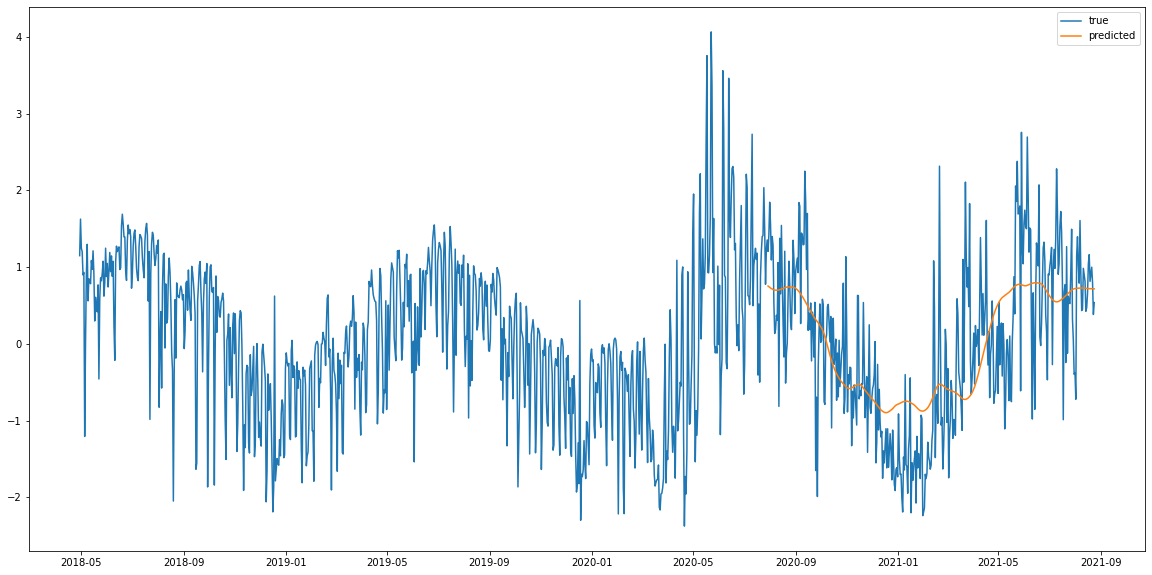

In [12]:
y_pred = model.predict(X_test)

def mape(pred, obs):
  return np.mean(np.abs((obs - pred) / obs)) * 100

print("MAPE:", mape(y_pred, y_test))
plt.figure(figsize=(20, 10))
plt.plot(data.index[PAST:], np.concatenate([y_train, y_test]), label="true")
plt.plot(data[split:].index, y_pred, label="predicted")
plt.legend()
plt.show()